# Notes

Modules are from: https://github.com/fhvilshoj/TorchLRP.git

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow
import cv2

from PIL import Image

import lrp

import torch
import torch.nn as nn
from torch import topk
import torchvision
from torchvision import models, transforms

# Define Transform

In [2]:
transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    ])

# Load model

In [3]:
# Load VGG-16 model
vgg = torchvision.models.vgg16(pretrained=True)
vgg.eval()

# Convert VGG model to LRP model
lrp_vgg = lrp.convert_vgg(vgg)

C:\Users\edvin\anaconda3\envs\deepimg\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\edvin\anaconda3\envs\deepimg\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Load labels

In [4]:
def load_synset_classes(file_path):
    # load the synset text file for labels
    all_classes = []
    with open(file_path, 'r') as f:
        for line in f.readlines():
            label = line.strip().split(':', 1)[1].strip(" '").split(',')[0]
            label = label.strip("'")  # Remove any remaining single quotes
            all_classes.append(label)
    return all_classes

# get all the classes in a list
all_classes = load_synset_classes('labels.txt')

# Load image

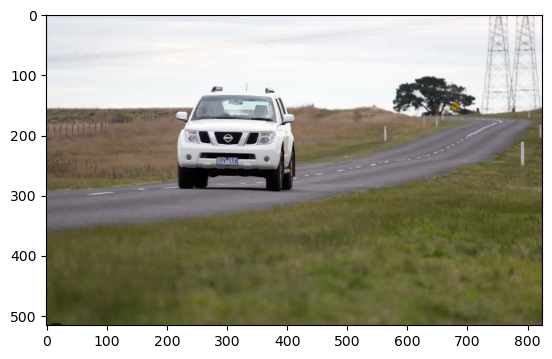

In [23]:
input_file = "car.jpg"

image = cv2.imread(input_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape

imshow(image)

# LRP


In [24]:
# Define softmax
softmax = nn.Softmax(dim=1)

# Apply the transforms to the image_copy tensor
image_t = transforms(image).unsqueeze(0).requires_grad_(True)

In [25]:
# Forward pass
y_hat = lrp_vgg.forward(image_t, explain=True, rule="alpha1beta0")

# probabilities and scores for top 3 predictions
probs = softmax(y_hat)
pred_scores, pred_idx = torch.topk(probs, 3)

# reformat
pred_scores = pred_scores.detach().numpy()[0]
pred_idx = pred_idx.detach().numpy()[0]

# get label
pred_label1 = all_classes[pred_idx[0]]
pred_label2 = all_classes[pred_idx[1]]
pred_label3 = all_classes[pred_idx[2]]


# Highest probability backprop
y_hat = lrp_vgg.forward(image_t, explain=True, rule="alpha1beta0")
first = y_hat[torch.arange(image_t.shape[0]), pred_idx[0]]
first.backward()
lrp1 = image_t.grad


# Second highest probability backprop
y_hat = lrp_vgg.forward(image_t, explain=True, rule="alpha1beta0")
second = y_hat[torch.arange(image_t.shape[0]), pred_idx[1]]
second.backward()
lrp2 = image_t.grad


# Third highest probability backprop
y_hat = lrp_vgg.forward(image_t, explain=True, rule="alpha1beta0")
third = y_hat[torch.arange(image_t.shape[0]), pred_idx[2]]
third.backward()
lrp3 = image_t.grad

# Preprocess

In [26]:
def preprocess(lrp,width,height):
    # Plot the processed explanation
    processed_lrp = lrp[0].detach().cpu().numpy().transpose(1, 2, 0)

    flat_image = cv2.cvtColor(processed_lrp, cv2.COLOR_BGR2GRAY)

    # Normalize the grayscale image
    normalized_image = cv2.normalize(flat_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    resized_image = cv2.resize(normalized_image, (width, height), interpolation=cv2.INTER_LINEAR)
    
    return resized_image

In [27]:
lrp1 = preprocess(lrp1,width,height)
lrp2 = preprocess(lrp2,width,height)
lrp3 = preprocess(lrp3,width,height)

# Plot

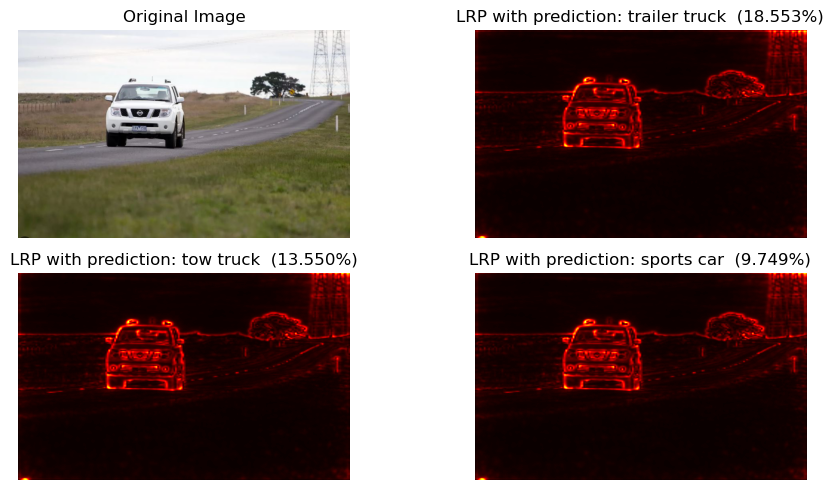

In [28]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# Plot the original image in the first subplot
axes[0,0].imshow(image)
axes[0,0].set_title('Original Image')
axes[0,0].axis('off')

# Plot the resized LRP heatmap in the second subplot
axes[0,1].imshow(lrp1, cmap='hot')
axes[0,1].set_title(f"LRP with prediction: {pred_label1}  ({100*pred_scores[0]:.3f}%)")
axes[0,1].axis('off')

# Plot the resized LRP heatmap in the second subplot
axes[1,0].imshow(lrp2, cmap='hot')
axes[1,0].set_title(f"LRP with prediction: {pred_label2}  ({100*pred_scores[1]:.3f}%)")
axes[1,0].axis('off')

# Plot the resized LRP heatmap in the second subplot
axes[1,1].imshow(lrp3, cmap='hot')
axes[1,1].set_title(f"LRP with prediction: {pred_label3}  ({100*pred_scores[2]:.3f}%)")
axes[1,1].axis('off')

# Adjust the space between the subplots
plt.tight_layout()

# Show the plots
plt.savefig("LRP_comparison_multiple.png")
plt.show()
